# Análisis de diferentes créditos hipotecários

### Integrantes: 
- Iñigo De Obeso Landeros
- Alejandro Frizard Aguilar
- Fabiana De La Peña Salazar

## Objetivo General

- Realizar un programa que permita observar al usuario las diversas opciónes de créditos hipotecarios para determinar cual es la mejor opción. 

### Objetivos específicos

- Crear una tabla de amortización que simule el proceso de pago del crédito en el tiempo.
- Obtener gráficas comparativas del pago de interés entre los diferentes bancos.
- Realizar un ejemplo utilizando una propiedad existente y determinar cual es el crédito más conveniente.




## Modelado del programa

#### Introducción

Los bancos ofrecen créditos hipotecarios con diversas características las cuales lo hacen más o menos atractivos para el mercado. Nosotros consideramos la tasa de interés, el valor mínimo para apertura de línea de crédito mínimo, el valor que cubre con respecto al valor total del inmueble y el plazo máximo de pago que ofrecen. 

Para ejemplificar el uso del programa creamos una situación ficticia en la cual una persona busca pedir un crédito para una propiedad de 6,500,000 mxn durante un plazo de 20 años con un enganche de 1,000,000 mxn y con pagos adicionales de 10000 mxn.


Para este ejemplo comparamos 4 créditos hipotecarios de los siguientes bancos en México: 

1. **BBVA**
Tasa del $10.0$% con valor mínimo de $400.000$ mxn, te cubre el $90$% del valor de la casa con un plazo máximo de 20 años.
2. **Citibanamex**
Tasa del $7.9$% con valor mínimo de $200.000$ mxn, te cubre el $85$% del valor de la casa con un plazo máximo de 20 años.
3. **Banorte**
Tasa del $8.0$% con valor mínimo de $750.000$ mxn, te cubre el $90$% del valor de la casa con un plazo máximo de 20 años.
4. **AFIRME**
Tasa del $8.9$% con valor mínimo de $200.000$ mxn, te cubre el $90$% del valor de la casa con un plazo máximo de 20 años.

El modelo utiliza una función de amortización que utiliza la tasa de interés anual, el número de años que dura el plazo, el número de pagos en el año, la cantidad que vas a pagar y los abonos extra que podrías hacer.

Luego realiza los siguientes pasos:

1. Asegura que los pagos adicionales sean negativos
2. Crea un indice de las fechas de pago
3. Construye un data frame de la amortización
4. Añande un índice por periódo
5. Calcula el pago tanto del capital principal como de los intereses mediante numpy finance
6. Redondea los valores
7. Agrega los pagos adicionales
8. Almacena los acumulativos de pagos para asegurar que no supere al capital principal original
9. Calcula el balance actual para cada periodo
10. Determina la última fecha de pago
11. Si se tienen pagos adicionales reasigna el valor al data frame
12. Elimina los periodos de pagos extra
13. Calcula el capital principal para la última columna
14. Calcula el total del pago para la última columna
15. Reduce a cero el capital principal adicional
16. Obtiene la información de pago en un data frame con orden de una columna
17. Le da formato al data frame 
18. Agrega una columna que muestre el pago por periodo y combina los pagos adicionales con los del periodo


In [12]:
pip install numpy-financial

Note: you may need to restart the kernel to use updated packages.


In [3]:
import pandas as pd
from datetime import date
import numpy as np
import numpy_financial as npf
from collections import OrderedDict
from dateutil.relativedelta import *
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
matplotlib.style.use('ggplot')

A continuación, la función para crear **tablas de amortización:**

In [4]:
def amortizar(interest_rate, years, payments_year, principal, addl_principal=0, start_date=date.today()):
    
    # 1
    if addl_principal > 0:
        addl_principal = -addl_principal
    
    # 2
    rng = pd.date_range(start_date, periods=years * payments_year, freq='MS')
    rng.name = "Payment_Date"
    
    # 3
    df = pd.DataFrame(index=rng,columns=['Payment', 'Principal', 'Interest', 
                                         'Addl_Principal', 'Curr_Balance'], dtype='float')
    
    # 4
    df.reset_index(inplace=True)
    df.index += 1
    df.index.name = "Period"
    
    # 5
    per_payment = npf.pmt(interest_rate/payments_year, years*payments_year, principal)
    df["Payment"] = per_payment
    df["Principal"] = npf.ppmt(interest_rate/payments_year, df.index, years*payments_year, principal)
    df["Interest"] = npf.ipmt(interest_rate/payments_year, df.index, years*payments_year, principal)
        
    # 6
    df = df.round(2) 
    
    # 7
    df["Addl_Principal"] = addl_principal
    
    # 8
    df["Cumulative_Principal"] = (df["Principal"] + df["Addl_Principal"]).cumsum()
    df["Cumulative_Principal"] = df["Cumulative_Principal"].clip(lower=-principal)
    
    # 9
    df["Curr_Balance"] = principal + df["Cumulative_Principal"]
    
    # 10
    try:
        last_payment = df.query("Curr_Balance <= 0")["Curr_Balance"].idxmax(axis=1, skipna=True)
    except ValueError:
        last_payment = df.last_valid_index()
    
    last_payment_date = "{:%m-%d-%Y}".format(df.loc[last_payment, "Payment_Date"])
        
    # 11
    if addl_principal != 0:
                
        # 12
        df = df.loc[0:last_payment].copy()
        
        # 13
        df.loc[last_payment, "Principal"] = -(df.loc[last_payment-1, "Curr_Balance"])
        
        # 14
        df.loc[last_payment, "Payment"] = df.loc[last_payment, ["Principal", "Interest"]].sum()
        
        # 15
        df.loc[last_payment, "Addl_Principal"] = 0
        
    # 16
    payment_info = (df[["Payment", "Principal", "Addl_Principal", "Interest"]]
                    .sum().to_frame().T)
       
    # 17
    payment_details = pd.DataFrame.from_dict(dict([('payoff_date', [last_payment_date]),
                                               ('Interest Rate', [interest_rate]),
                                               ('Number of years', [years])
                                              ]))
    # 18
    payment_details["Period_Payment"] = round(per_payment, 2) + addl_principal
    
    payment_summary = pd.concat([payment_details, payment_info], axis=1)
    return df, payment_summary

## APLICACIÓN GENERAL Y COMPARATIVA:
- En las siguientes celdas mandamos a llamar varias funciones de "**amortizar**" para los cuatro créditos hipotecarios mencionados previamente. 
- Como se puede ver, cada uno tiene su **tasa** respectiva junto con su línea **mínima** de crédito.


In [5]:
tabla_amort1, data1 = amortizar(0.1, 10, 12, 400000, addl_principal=0)
tabla_amort2, data2 = amortizar(0.079, 10, 12, 200000, addl_principal=0)
tabla_amort3, data3 = amortizar(0.08, 10, 12, 750000, addl_principal=0)
tabla_amort4, data4 = amortizar(0.089, 10, 12, 200000, addl_principal=0)

Aquí, se manda a llamar la primera tabla de amortización:

In [6]:
tabla_amort1

,Payment_Date,Payment,Principal,Interest,Addl_Principal,Curr_Balance,Cumulative_Principal
Period,,,,,,,
1,2022-12-01,-5286.03,-1952.70,-3333.33,0,398047.30,-1952.70
2,2023-01-01,-5286.03,-1968.97,-3317.06,0,396078.33,-3921.67
3,2023-02-01,-5286.03,-1985.38,-3300.65,0,394092.95,-5907.05
4,2023-03-01,-5286.03,-2001.92,-3284.11,0,392091.03,-7908.97
5,2023-04-01,-5286.03,-2018.60,-3267.43,0,390072.43,-9927.57
...,...,...,...,...,...,...,...
116,2032-07-01,-5286.03,-5071.18,-214.85,0,20710.82,-379289.18
117,2032-08-01,-5286.03,-5113.44,-172.59,0,15597.38,-384402.62
118,2032-09-01,-5286.03,-5156.05,-129.98,0,10441.33,-389558.67


### Tabla de amortización general y gráfica comparativa de pagos respecto al tiempo
- Como se pudieron dar cuenta, en las celdas de arriba donde se definía "**tabla_amortN**" había una segunda variable a donde se guardaban los datos, a esta le denominamos "**dataN**".
- Consecuentemente, se puede apreciar que cuando se llama a "**dataN**" es un resúmen del crédito hipotecario.

In [7]:
pd.concat([data1, data2, data3, data4], ignore_index=True)

,payoff_date,Interest Rate,Number of years,Period_Payment,Payment,Principal,Addl_Principal,Interest
0,11-01-2032,0.100,10,-5286.03,-634323.6,-400000.03,0.0,-234323.53
1,11-01-2032,0.079,10,-2416.00,-289920.0,-200000.01,0.0,-89919.60
2,11-01-2032,0.080,10,-9099.57,-1091948.4,-749999.94,0.0,-341948.39
3,11-01-2032,0.089,10,-2522.70,-302724.0,-200000.00,0.0,-102724.44


## GRÁFICAS Y LINEAS DE TIEMPO:
- En el siguiente apartado hicimos una gráfica en donde se comparaban los créditos de los distintos bancos y la deuda remanente a través del tiempo.

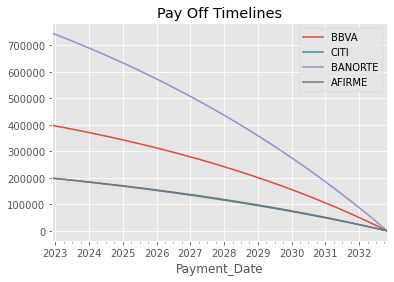

In [8]:
fig, ax = plt.subplots(1, 1)
tabla_amort1.plot(x='Payment_Date', y='Curr_Balance', label="BBVA", ax=ax)
tabla_amort2.plot(x='Payment_Date', y='Curr_Balance', label="CITI", ax=ax)
tabla_amort3.plot(x='Payment_Date', y='Curr_Balance', label="BANORTE", ax=ax)
tabla_amort4.plot(x='Payment_Date', y='Curr_Balance', label="AFIRME", ax=ax)
plt.title("Pay Off Timelines");

### ¡OJO! 
- Observese lo que sucede cuando se agregan pagos adicionales al crédito hipotecario, en este caso $10,000$ mxn adicionales a **BANORTE**.

In [9]:
tabla_amort1, data1 = amortizar(0.1, 10, 12, 400000, addl_principal=0)
tabla_amort2, data2 = amortizar(0.079, 10, 12, 200000, addl_principal=0)
tabla_amort3, data3 = amortizar(0.08, 10, 12, 750000, addl_principal=10000)
tabla_amort4, data4 = amortizar(0.089, 10, 12, 200000, addl_principal=0)

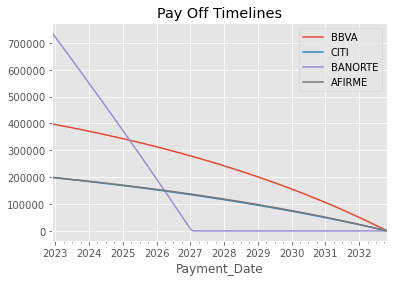

In [10]:
fig, ax = plt.subplots(1, 1)
tabla_amort1.plot(x='Payment_Date', y='Curr_Balance', label="BBVA", ax=ax)
tabla_amort2.plot(x='Payment_Date', y='Curr_Balance', label="CITI", ax=ax)
tabla_amort3.plot(x='Payment_Date', y='Curr_Balance', label="BANORTE", ax=ax)
tabla_amort4.plot(x='Payment_Date', y='Curr_Balance', label="AFIRME", ax=ax)
plt.title("Pay Off Timelines");

¡El crédito se acaba pagando el **doble** de rápido!

# PARA COMPARAR DIFERENTES TASAS DE INTERÉS Y PLAZOS:
**OBJETIVO**: Darnos cuenta el monto total que estamos pagando por una línea de crédito de 750 mil mxn.

**¿Cómo?:** se comparan las diferentes tasas con el mismo monto, en este caso siendo 750 mil mxn ya que es el minimo de Banorte.


In [11]:
tabla_amort1, data1 = amortizar(0.1, 20, 12, 750000, addl_principal=0)
tabla_amort2, data2 = amortizar(0.079, 20, 12, 750000, addl_principal=0)
tabla_amort3, data3 = amortizar(0.08, 20, 12, 750000, addl_principal=0)
tabla_amort4, data4 = amortizar(0.089, 20, 12, 750000, addl_principal=0)

### Tabla comparativa:
- Podemos observar como el crédito de menos convenencia es es **BBVA**:

In [12]:
pd.concat([data1, data2, data3, data4], ignore_index=True)

,payoff_date,Interest Rate,Number of years,Period_Payment,Payment,Principal,Addl_Principal,Interest
0,11-01-2042,0.100,20,-7237.66,-1737038.4,-749999.94,0.0,-987038.98
1,11-01-2042,0.079,20,-6226.70,-1494408.0,-749999.96,0.0,-744409.02
2,11-01-2042,0.080,20,-6273.30,-1505592.0,-750000.07,0.0,-755592.05
3,11-01-2042,0.089,20,-6699.78,-1607947.2,-750000.07,0.0,-857948.38


### Pago de intereses a lo largo del tiempo por banco:
- Las siguientes gráficas nos permiten conocer la cantidad de intereses que pagamos anualmente en un crédito.

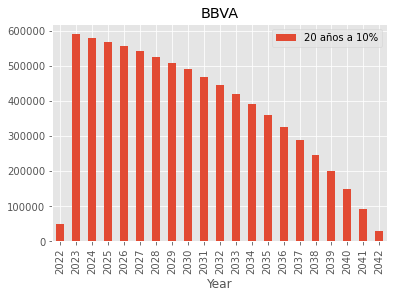

In [26]:
fig, ax = plt.subplots(1, 1)

y1_tabla_amort = tabla_amort1.set_index('Payment_Date').resample("A")["Interest"].sum().abs().reset_index()
y1_tabla_amort["Year"] = y1_tabla_amort["Payment_Date"].dt.year
y1_tabla_amort.plot(kind="bar", x="Year", y="Interest", ax=ax, label="20 años a 10%")

plt.title("BBVA");

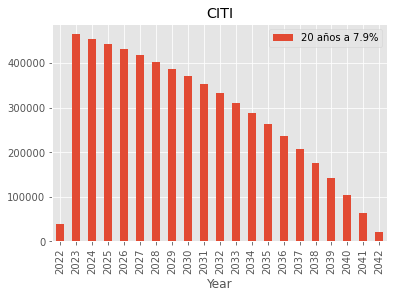

In [27]:
fig, ax = plt.subplots(1, 1)

y2_tabla_amort = tabla_amort2.set_index('Payment_Date').resample("A")["Interest"].sum().abs().reset_index()
y2_tabla_amort["Year"] = y2_tabla_amort["Payment_Date"].dt.year
y2_tabla_amort.plot(kind="bar", x="Year", y="Interest", ax=ax, label="20 años a 7.9%")

plt.title("CITI");

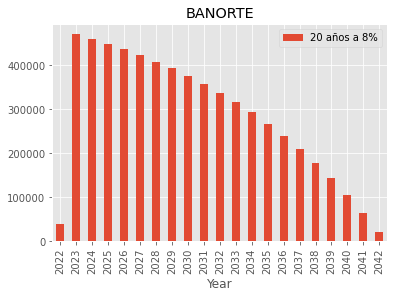

In [28]:
fig, ax = plt.subplots(1, 1)

y3_tabla_amort = tabla_amort3.set_index('Payment_Date').resample("A")["Interest"].sum().abs().reset_index()
y3_tabla_amort["Year"] = y3_tabla_amort["Payment_Date"].dt.year
y3_tabla_amort.plot(kind="bar", x="Year", y="Interest", ax=ax, label="20 años a 8%")

plt.title("BANORTE");

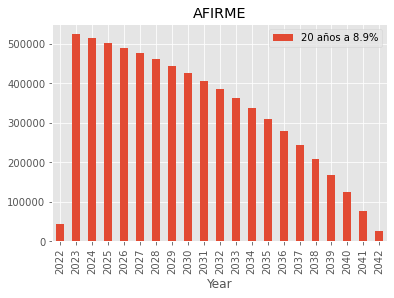

In [29]:
fig, ax = plt.subplots(1, 1)

y4_tabla_amort = tabla_amort4.set_index('Payment_Date').resample("A")["Interest"].sum().abs().reset_index()
y4_tabla_amort["Year"] = y4_tabla_amort["Payment_Date"].dt.year
y4_tabla_amort.plot(kind="bar", x="Year", y="Interest", ax=ax, label="20 años a 8.9%")

plt.title("AFIRME");

## Conclusiones :

Es importante realizar estas simulaciones para conocer cuales de las opciones del mercado son las más convenientes, cuanto es lo que vamos a terminar pagando por nuestro inmueble y como cambian estos valores si vamos modificando el tiempo en el cual pagaremos nuestro crédito y los pagos adicionales que podemos realizar para reducir el pago de intereses lo más posible.

## Presentación: 
- https://www.canva.com/design/DAFTchkVN10/U1SlHBUNn6i7W7WfJVsu7w/view?utm_content=DAFTchkVN10&utm_campaign=designshare&utm_medium=link2&utm_source=sharebutton

## Referencias:

- Moffitt, Chris. “Building a Financial Model with Pandas - Version&nbsp;2.” Practical Business Python Atom, 19 Dec. 2016, https://pbpython.com/amortization-model-revised.html. 
- “Top 10 Créditos Hipotecarios (Tasas Diciembre 2022).” HelloSafe, 22 Sept. 2022, https://hellosafe.com.mx/credito-hipotecario. 
- Vidaurri Aguirre, Héctor Manuel. *Ingeniería económica básica*, ISBN: 978-607-519-017-4. (Disponible en biblioteca)